# Домашнее задание 4. Конструирование текстовых признаков из твитов пользователей

## Сбор данных

Первый этап - сбор твитов пользователей. Необходимо подключаться к Twitter API и запрашивать твиты по id пользователя. 
Подключение к API подробно описано в ДЗ 1.

In [1]:
import twitter
import pandas as pd
import numpy as np
import pylab as pl
import mpl_toolkits.basemap as bm
import twitter
import requests
import datetime
import dateutil
import csv
import time
from collections import defaultdict
import os
import json
from sklearn.feature_extraction import DictVectorizer
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
%pylab inline


TRAINING_SET_URL = "twitter_train.txt"
df_users = pd.read_csv(TRAINING_SET_URL, sep=",", header=0)

Populating the interactive namespace from numpy and matplotlib


In [56]:
df_users.head()

,uid,cat
0,40585382,1
1,30005269,0
2,3314758074,0
3,14311688,0
4,110457801,0


In [3]:
CONSUMER_KEY = "ukWoXoZoXYdToz87cEMHVl6OE"
CONSUMER_SECRET = "h2fBQrH6303e7HxjK0zpUMeQ4IHLTjP19f3j5vneDeq9q6s9JE"

ACCESS_TOKEN_KEY = "932523067-UYNQhhmFSoO8HYKyX5aYovqObIt2kHop0Z8SY70f"
ACCESS_TOKEN_SECRET = "zo1w5ScxM86WE5hgBihnXSwkp2stX5ihPjlcgzGCZ0TNA"

api = twitter.Api(consumer_key=CONSUMER_KEY, 
                  consumer_secret=CONSUMER_SECRET, 
                  access_token_key=ACCESS_TOKEN_KEY, 
                  access_token_secret=ACCESS_TOKEN_SECRET)

Для получения твитов пользователя может быть использован метод GetUserTimeline из библиотеки python-twitter. Он позволяет получить не более 200 твитов пользователя. По каждому пользователю достаточно собрать 200 твитов.

Метод имеет ограничение по количеству запросов в секунду. Для получения информации о промежутке времени, которое необходимо подождать для повторного обращения к API может быть использован метод `GetSleepTime`. Для получения информации об ограничениях запросов с помощью метода `GetUserTimeLine` необходимо вызывать `GetSleepTime` с параметром "statuses/user_timeline".

Метод GetUserTimeline возвращает объекты типа Status. У этих объектов есть метод AsDict, который позволяет представить твит в виде словаря.

Id пользователей необходимо считать из файла, как было сделано в ДЗ 1.

Необходимо реализовать функцию `get_user_tweets(user_id)`. Входной параметр - id пользователя из файла. Возвращаемое значение - массив твитов пользователя, где каждый твит представлен в виде словаря. Предполагается, что информация о пользователе содержится в твитах, которые пользователь написал сам. Это означает, что можно попробовать отфильтровать ответы другим пользователям, ссылки и ретвиты, а так же картинки и видео, так как наша цель - найти текстовую информацию.

In [4]:
def get_user_tweets(user_id):
    """returns list of tweets as dicts"""
    tweets = []
    try:
        tweets = api.GetUserTimeline(user_id, count=200, include_rts=False, exclude_replies=True, trim_user=True)
    except twitter.TwitterError as e:                
        sec = api.GetSleepTime('/statuses/user_timeline')
        print "Sleep for {}".format(sec)
        time.sleep(sec)        

    tweets = map(lambda s: s.AsDict(), tweets)
    tweets = filter(lambda t: t['retweeted'] == False, tweets)
    tweets = filter(lambda t: t['lang'] == u'en', tweets)
    tweets = filter(lambda t: len(re.findall(r'https?://[^\s<>"]+|www\.[^\s<>"]+', t['text'])) == 0, tweets)
                
    print "Tweets number: {}".format(len(tweets))    
    return tweets   

    '''    
    return [{'lang': u'en', 
             'favorited': False, 
             'truncated': False, 
             'text': u"So now I'm on the floor tweeting about it PROB w a black eye n swollen nose", 
             'created_at': u'Mon Apr 06 05:59:50 +0000 2015', 
             'retweeted': False, 
             'source': u'<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>', 
             'user': {'id': 984121344}, 
             'id': 584958674528964608}]
    '''

## Разбор текста твита

Обработка текста предполагает разбиение текста на отдельные элементы - параграфы, предложения, слова. Мы будем преобразовывать текст твита к словам. Для этого текст необходимо разбить на слова. Сделать это можно, например, с помощью регулярного выражения.

Необходимо реализовать функцию, `get_words(text)`. Входной параметр - строка с текстом. Возвращаемое значение - массив строк (слов). Обратите внимание, что нужно учесть возможное наличие пунктуации и выделить по возможности только слова. 

In [5]:
import re, string
def get_words(text):
    text = unicode(text)
    """returns list of words"""
    a = re.sub(r'[^\w\s]+|[\d]+', r'',text).strip().split()
    return a

In [6]:
print get_words("Here are different words!")

[u'Here', u'are', u'different', u'words']


In [7]:
test_text = "Here=) are!1!!1 different.. :3 words! I am eating potato"
print get_words(test_text)

[u'Here', u'are', u'different', u'words', u'I', u'am', u'eating', u'potato']


Далее полученные слова необходимо привести к нормальной форме. То есть привести их к форме единственного числа настоящего времени и пр. Сделать это можно с помощью библиотеки nltk. Информацию по загрузке, установке библиотеки и примерах использования можно найти на сайте http://www.nltk.org/

Для загрузки всех необходимых словарей можно воспользоваться методом download из библиотеки nltk.

In [8]:
import nltk
# nltk.download()
from nltk import WordNetLemmatizer
from nltk.corpus import stopwords

In [9]:
def get_tokens(words):
    lemmatizer = WordNetLemmatizer()
    return [lemmatizer.lemmatize(word.lower()) for word in words if word not in nltk.corpus.stopwords.words('english')]

Для дальнейшей обработки слова должны быть приведены к нижнему регистру. 

Для приведения к нормальной форме можно использовать `WordNetLemmatizer` из библиотеки nltk. У этого класса есть метод `lemmatize`.

Также необходимо убрать из текста так называемые стоп-слова. Это часто используемые слова, не несущие смысловой нагрузки для наших задач. Сделать это можно с помощью `stopwords` из nltk.corpus

Необходимо реализовать функцию `get_tokens(words)`. Входной параметр - массив слов. Возвращаемое значение - массив токенов.

In [10]:
def get_tokens(words):
    lemmatizer = WordNetLemmatizer()
    return [lemmatizer.lemmatize(word.lower()) for word in words if word not in nltk.corpus.stopwords.words('english')]

In [11]:
print get_tokens(["here", "are", "different", "words"])

['different', u'word']


In [12]:
print get_tokens(get_words(test_text))

[u'here', u'different', u'word', u'i', u'eating', u'potato']


Необходимо реализовать функцию `get_tweet_tokens(tweet)`. Входной параметр - текст твита. Возвращаемое значение -- токены твита. 

In [13]:
def get_tweet_tokens(tweet):
    # your code here
    return get_tokens(get_words(tweet['text']))

In [24]:
user_records = []
tmp_file_name = 'tmp_user_tweet_records'
if os.path.exists(tmp_file_name):
    with open(tmp_file_name) as f:
        for line in f:
            try:
                user_records.append(json.loads(line))
            except:
                continue

    

In [25]:
df1 = df_users[:10]

Необходимо реализовать функцию `collect_users_tokens()`. Функция должна сконструировать матрицу признаков пользователей. В этой матрице строка - пользователь. Столбец - токен. На пересечении - сколько раз токен встречается у пользователя.
Для построения матрицы можно использовать `DictVectorizer` из `sklearn.feature_extraction`.

In [26]:
f = open(tmp_file_name, 'a')
def collect_users_tokens(df_users):
    """returns users list and list of user dicts. Each dict contains frequence of user tokens"""
    users = df_users["uid"]
    user_dict = []
    for user in users:
        tweets = get_user_tweets(user)
        f.write(json.dumps(tweets))
        f.write('\n')
        tokens = []
        token_count = {}
        for tweet in tweets:
            tweet_tokens = get_tweet_tokens(tweet)
    
            for token in tweet_tokens:
                if token not in token_count:
                    token_count[token] = tokens.count(token)
                else:
                    token_count[token]+= tweet_tokens.count(token)
        
        user_dict.append(token_count)
        
    
    return list(users),user_dict
    
    #return [12345], [{u'eye': 1, u'floor': 1, u'tweeting': 1, u'n': 1, u'black': 1, u'nose': 1, u'w': 1, u'swollen': 1, u"i'm": 1, u'prob': 1}]


In [27]:
import pandas as pd
from collections import defaultdict
import json
from sklearn.feature_extraction import DictVectorizer


TRAINING_SET_URL = "twitter_train.txt"
EXAMPLE_SET_URL = "twitter_example.txt"
df_users_train = pd.read_csv(TRAINING_SET_URL, sep=",", header=0, names=["uid", "cat"])
df_users_ex = pd.read_csv(EXAMPLE_SET_URL, sep=",", header=0, names=["uid", "cat"])
df_users_ex['cat'] = None
df_users = pd.concat([df_users_train, df_users_ex])

users, users_tokens = collect_users_tokens(df_users)
v = DictVectorizer()
vs = v.fit_transform(users_tokens)

Tweets number: 40
Tweets number: 35
Sleep for 0
Tweets number: 0
Tweets number: 32
Tweets number: 66
Tweets number: 59
Tweets number: 1
Tweets number: 113
Tweets number: 35
Tweets number: 105
Tweets number: 15
Tweets number: 63
Tweets number: 105
Tweets number: 39
Tweets number: 59
Tweets number: 21
Tweets number: 6
Tweets number: 13
Tweets number: 62
Tweets number: 47
Tweets number: 15
Tweets number: 146
Tweets number: 0
Tweets number: 61
Tweets number: 52
Tweets number: 28
Tweets number: 80
Tweets number: 16
Tweets number: 11
Tweets number: 34
Tweets number: 37
Tweets number: 31
Tweets number: 106
Tweets number: 169
Tweets number: 41
Tweets number: 30
Tweets number: 26
Tweets number: 64
Tweets number: 94
Tweets number: 77
Tweets number: 48
Tweets number: 49
Tweets number: 85
Tweets number: 10
Tweets number: 20
Tweets number: 78
Tweets number: 58
Tweets number: 63
Tweets number: 11
Tweets number: 10
Tweets number: 19
Tweets number: 45
Tweets number: 116
Tweets number: 31
Tweets number

In [30]:
f.close()

In [31]:
vs

<6898x154179 sparse matrix of type '<type 'numpy.float64'>'
	with 486183 stored elements in Compressed Sparse Row format>

In [32]:
import numpy as np
np.savez("out_4.dat", data=vs, users=users, users_tokens=users_tokens )

Далее для получения представления о полученной информацию о токенах предлагается отобразить ее в виде облака тэгов. [Подсказка](http://anokhin.github.io/img/tag_cloud.png). 

In [54]:
def draw_tag_cloud(v, vs):
    """Draws tag cloud of found tokens"""
    plt.rcParams['figure.figsize'] = (20.0, 20.0)
    vs_array = np.sum(vs.toarray(), axis=0)

    
    wordcloud = WordCloud(                          
                          stopwords=set(list(STOPWORDS) + list(nltk.corpus.stopwords.words('english'))),
                          background_color='black',
                          width=1800,
                          height=1400,
                          max_words=750
                         ).fit_words(zip(v.get_feature_names(), vs_array))

    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()

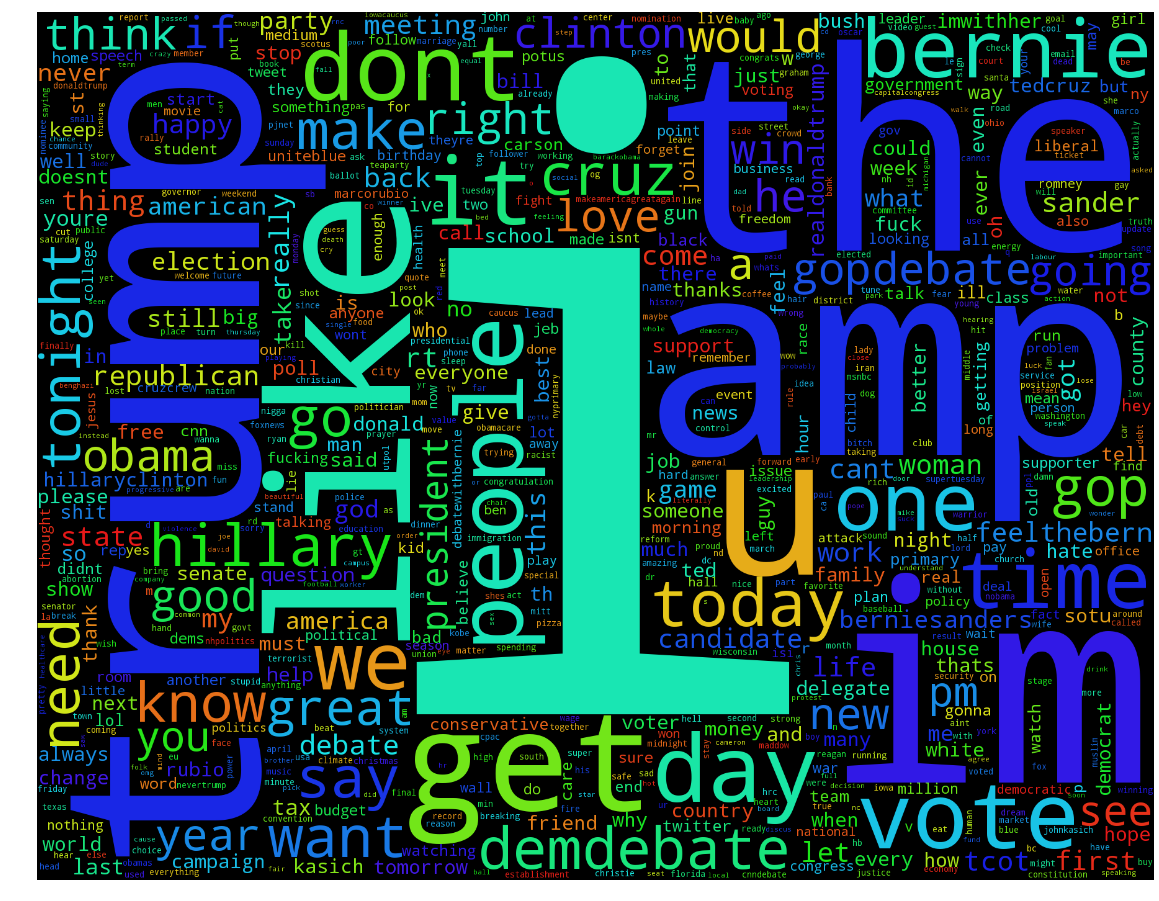

In [55]:
draw_tag_cloud(v, vs)